In [1]:
# General Imports
import numpy as np

# Visualisation Imports
import matplotlib.pyplot as plt

# Scikit Imports
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Qiskit Imports
from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

In [2]:
# Load digits dataset
data=np.genfromtxt('alloy-property-avg.csv',delimiter=",",skip_header=1)
#digits = datasets.load_digits(n_class=2)
print(len(data))
print(data[0])
print(data[0][0:-1])
X,y=[],[]
for i in range(len(data)):
    X.append(data[i][0:-1]),y.append(data[i][-1])
print("X,y: ",X[0],y[0])
max_arr=np.max(X,axis=0)
print("max_arr: ",max_arr,X/max_arr)
X=X/max_arr
print("renormalized X: ",X)
X5=np.random.random((len(data),15))
print("X5: ",X5)
Xnew=np.append(X, X5, axis=1)
print("Xnew: ",Xnew)
# Plot example '0' and '1'
#fig, axs = plt.subplots(1, 2, figsize=(6,3))
#axs[0].set_axis_off()
#axs[0].imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
#axs[1].set_axis_off()
#axs[1].imshow(digits.images[100], cmap=plt.cm.gray_r, interpolation='nearest')
#plt.show()

1252
[1.46502e+02 3.01840e+03 3.97400e+01 1.21400e+00 1.92800e+02 8.50600e-06
 7.58760e+03 1.20600e+01 1.41620e+03 3.22000e+01 1.00077e+04 2.10400e+02
 1.32000e+01 3.00000e+00 3.05000e+02 0.00000e+00]
[1.46502e+02 3.01840e+03 3.97400e+01 1.21400e+00 1.92800e+02 8.50600e-06
 7.58760e+03 1.20600e+01 1.41620e+03 3.22000e+01 1.00077e+04 2.10400e+02
 1.32000e+01 3.00000e+00 3.05000e+02]
X,y:  [1.46502e+02 3.01840e+03 3.97400e+01 1.21400e+00 1.92800e+02 8.50600e-06
 7.58760e+03 1.20600e+01 1.41620e+03 3.22000e+01 1.00077e+04 2.10400e+02
 1.32000e+01 3.00000e+00 3.05000e+02] 0.0
max_arr:  [2.25600e+02 5.59190e+03 4.49700e+02 2.50100e+00 2.38000e+02 1.75500e-01
 2.23125e+04 4.31000e+01 3.40288e+03 1.10925e+02 2.45970e+04 3.18750e+03
 4.15000e+02 6.95000e+00 7.95200e+02] [[0.6493883  0.53978075 0.08837002 ... 0.03180723 0.43165468 0.38355131]
 [0.5089273  0.33521701 0.15788303 ... 0.54698795 0.43165468 0.20246479]
 [0.24797606 0.52911354 0.11785635 ... 0.03915663 0.43165468 0.41939135]
 ...
 [0

In [3]:
# Split dataset
#sample_train, sample_test, label_train, label_test = train_test_split(
#     digits.data, digits.target, test_size=0.2, random_state=22)
sample_train, sample_test, label_train, label_test = train_test_split(
    X,y, test_size=0.2, random_state=22)
print(sample_train[0])

# Reduce dimensions
n_dim = 4 #6 #5 #4
pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)
print(sample_train[0])
# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)
print(sample_train[0])
# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)
print(sample_train[0])
# Select
train_size = 200 # 20*2*2*2 #100
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 40 # 5*2*2*2 #20
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

[7.91422872e-01 7.84402439e-01 6.78229931e-01 8.79648141e-01
 5.95588235e-01 2.79202279e-09 9.44112045e-01 6.02204176e-01
 7.18861670e-01 1.27203065e-01 1.47026060e-02 4.61333333e-02
 3.50602410e-01 8.63309353e-01 7.07997988e-01]
[ 0.85179262 -0.01827728  0.30029577  0.02465719]
[ 1.7892647  -0.07492616  1.4337202   0.19051935]
[ 0.70111418 -0.11226165  0.17271665  0.01736976]


In [4]:
print(sample_train[0], label_train[0])
print(sample_test[0], label_test[0])

[ 0.70111418 -0.11226165  0.17271665  0.01736976] 0.0
[-0.2168864   0.69441576 -0.24023611 -0.0940706 ] 0.0


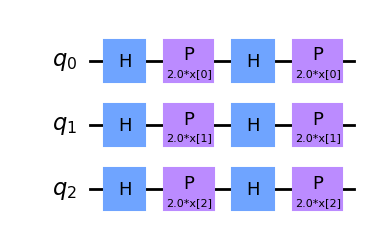

In [5]:
# 3 features, depth 2
map_z = ZFeatureMap(feature_dimension=3, reps=2)
map_z.decompose().draw('mpl')

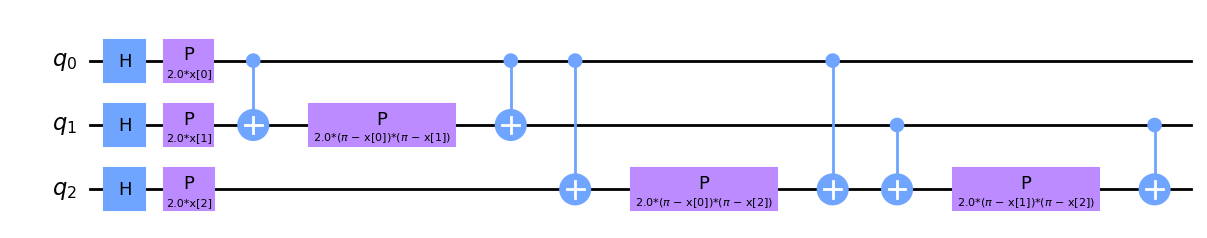

In [8]:
# 3 features, depth 1
map_zz = ZZFeatureMap(feature_dimension=3, reps=1)
map_zz.decompose().draw('mpl')

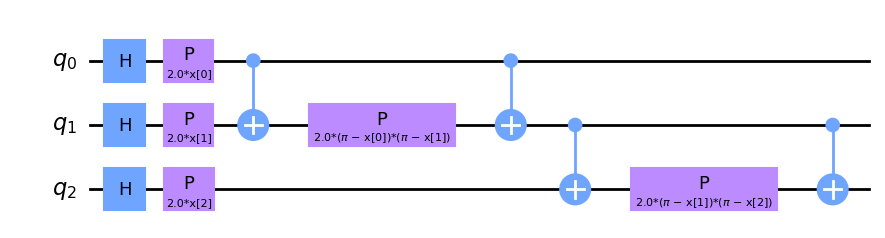

In [9]:
# 3 features, depth 1, linear entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='linear')
map_zz.decompose().draw('mpl')

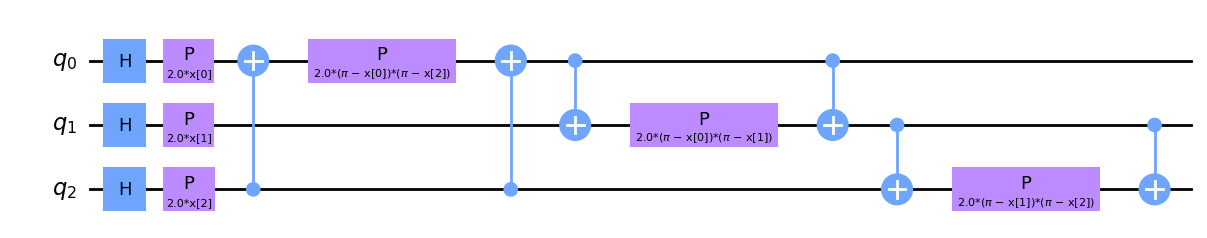

In [10]:
# 3 features, depth 1, circular entanglement
map_zz = ZZFeatureMap(feature_dimension=3, reps=1, entanglement='circular')
map_zz.decompose().draw('mpl')

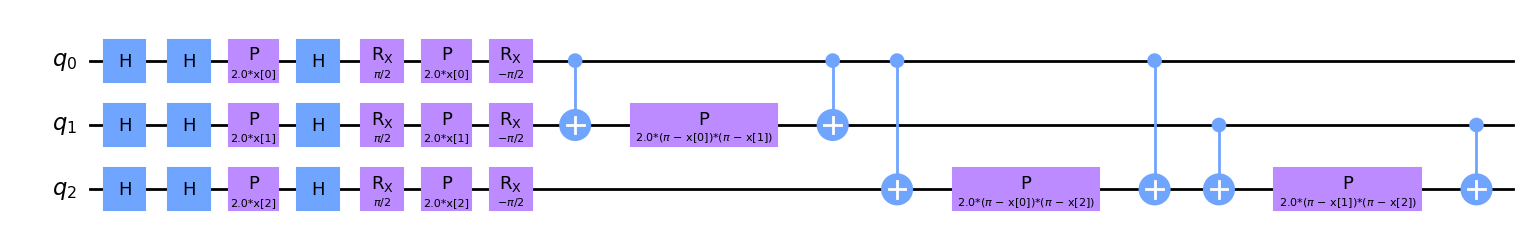

In [11]:
# 3 features, depth 1
map_pauli = PauliFeatureMap(feature_dimension=3, reps=1, paulis = ['X', 'Y', 'ZZ'])
map_pauli.decompose().draw('mpl')

In [12]:
def custom_data_map_func(x):
    coeff = x[0] if len(x) == 1 else reduce(lambda m, n: m * n, np.sin(np.pi - x))
    return coeff

In [13]:
map_customdatamap = PauliFeatureMap(feature_dimension=3, reps=1, paulis=['Z','ZZ'],
                                    data_map_func=custom_data_map_func)

#map_customdatamap.draw() # qiskit isn't able to draw the circuit with np.sin in the custom data map 

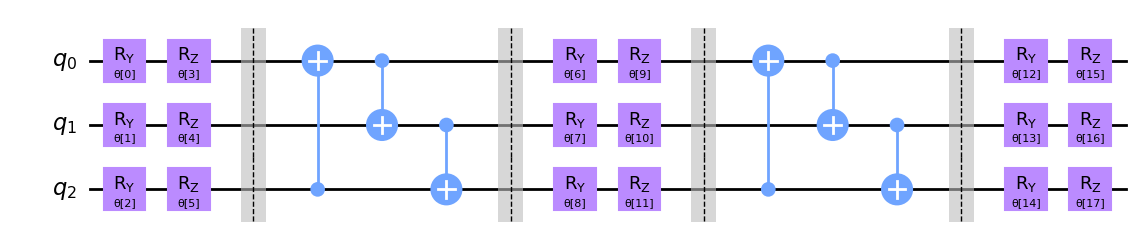

In [83]:
twolocal = TwoLocal(num_qubits=3, reps=2, rotation_blocks=['ry','rz'], 
               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
twolocal.decompose().draw('mpl')

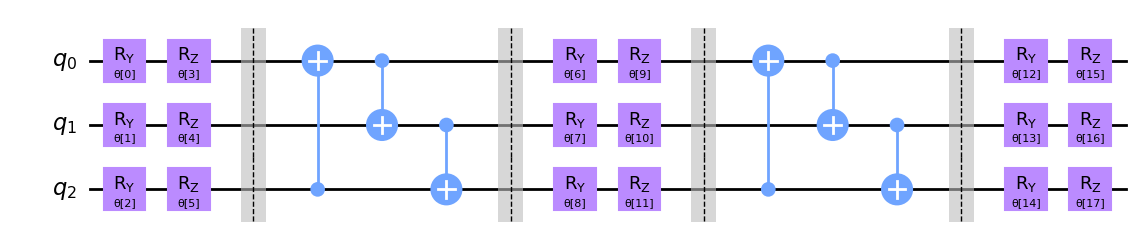

In [15]:
twolocaln = NLocal(num_qubits=3, reps=2,
               rotation_blocks=[RYGate(Parameter('a')), RZGate(Parameter('a'))], 
               entanglement_blocks=CXGate(), 
               entanglement='circular', insert_barriers=True)
twolocaln.decompose().draw('mpl')

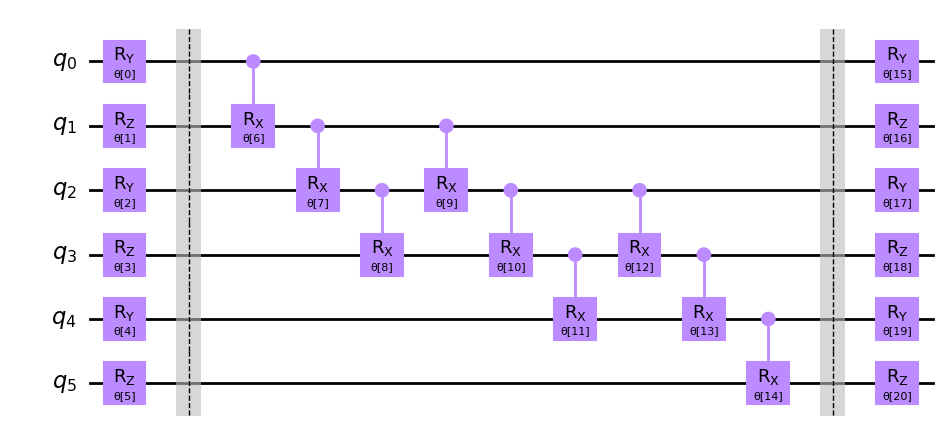

In [16]:
# rotation block:
rot = QuantumCircuit(2)
params = ParameterVector('r', 2)
rot.ry(params[0], 0)
rot.rz(params[1], 1)

# entanglement block:
ent = QuantumCircuit(4) 
params = ParameterVector('e', 3)
ent.crx(params[0], 0, 1)
ent.crx(params[1], 1, 2)
ent.crx(params[2], 2, 3)

nlocal = NLocal(num_qubits=6, rotation_blocks=rot, entanglement_blocks=ent, 
                entanglement='linear', insert_barriers=True)
nlocal.decompose().draw('mpl')

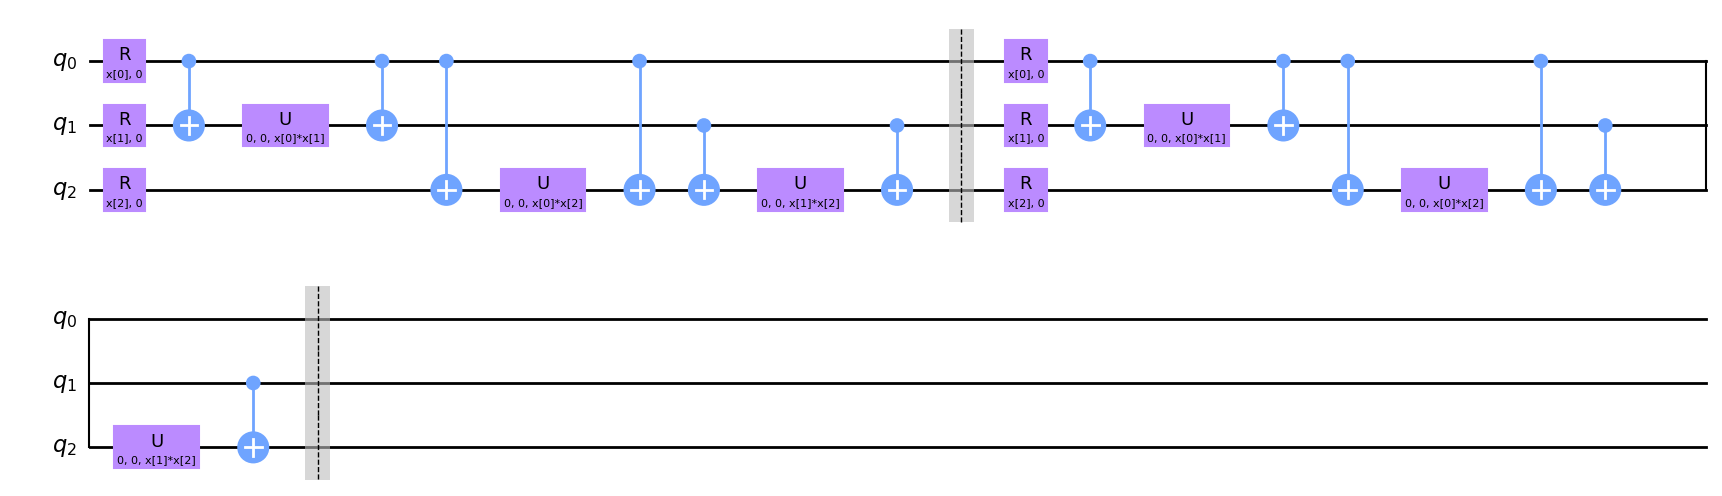

In [17]:
qubits = 3     
repeats = 2

x = ParameterVector('x', length=qubits)
var_custom = QuantumCircuit(qubits)

for _ in range(repeats):
    for i in range(qubits):
        var_custom.rx(x[i], i)
    for i in range(qubits):
        for j in range(i + 1, qubits):
            var_custom.cx(i, j)
            var_custom.p(x[i] * x[j], j)
            var_custom.cx(i, j)
    var_custom.barrier()
            
var_custom.decompose().draw('mpl')

In [6]:
print(sample_train[0])

[ 0.70111418 -0.11226165  0.17271665  0.01736976 -0.47808012 -0.73780652]


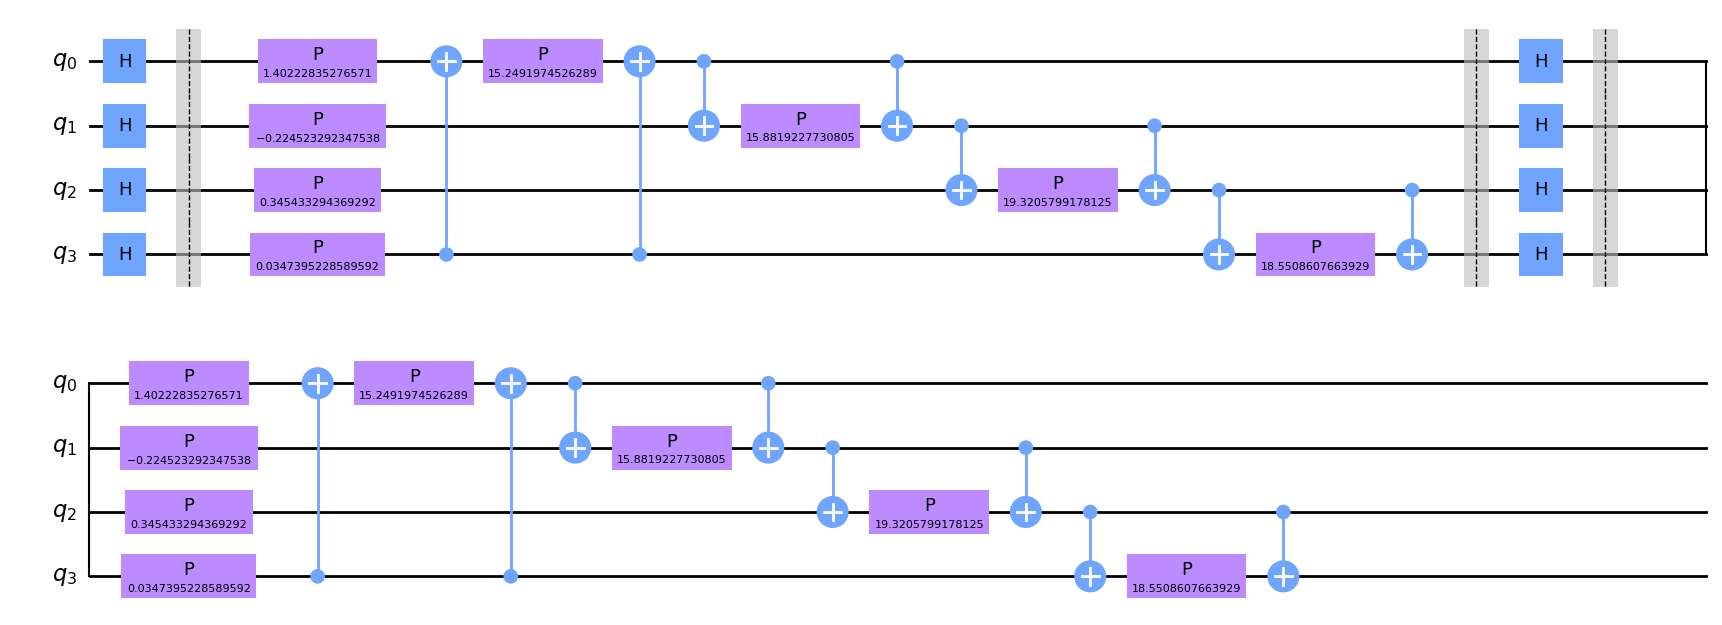

In [10]:
encode_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='circular', insert_barriers=True)
encode_circuit = encode_map.bind_parameters(sample_train[0])
encode_circuit.decompose().draw(output='mpl')

In [5]:
from qiskit import BasicAer
#zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear', insert_barriers=True)
zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='circular', insert_barriers=True)
#zz_map = ZFeatureMap(feature_dimension=6, reps=3)
#zz_map = PauliFeatureMap(feature_dimension=6, reps=3, paulis = ['X', 'Y', 'ZZ'])
#zz_map = TwoLocal(num_qubits=6, reps=2, rotation_blocks=['ry','rz'], 
#               entanglement_blocks='cx', entanglement='circular', insert_barriers=True)
#zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=BasicAer.get_backend('statevector_simulator'))
print(sample_train[0])
print(sample_train[1])
zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
#zz_circuit = zz_kernel.construct_circuit_with_feature_map(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

#----------------simulator--------------------
#backend = Aer.get_backend('qasm_simulator')
backend = BasicAer.get_backend('qasm_simulator')

job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)


[ 0.70111418 -0.11226165  0.17271665  0.01736976]
[ 0.50814286 -0.11388106 -0.67083228 -0.20491797]


In [6]:
counts['0000']/sum(counts.values())
counts
#counts['000000000000000']/sum(counts.values())

{'1011': 1650,
 '1111': 1372,
 '1010': 804,
 '1100': 538,
 '0100': 379,
 '0000': 106,
 '1000': 1169,
 '1101': 119,
 '0110': 406,
 '1110': 187,
 '0010': 275,
 '0001': 320,
 '1001': 282,
 '0111': 280,
 '0011': 233,
 '0101': 72}

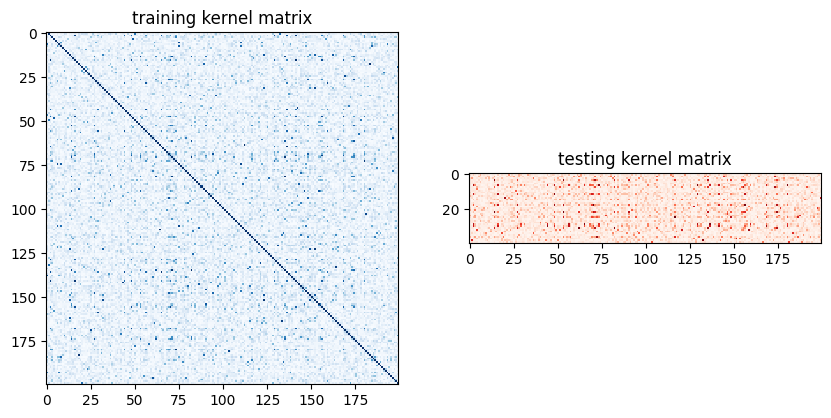

In [7]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

In [8]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, label_train)
zzpc_score = zzpc_svc.score(matrix_test, label_test)

print(f'Precomputed kernel classification test score: {zzpc_score}')

Precomputed kernel classification test score: 0.65


In [6]:
#----------------ibm quantum computer---------
# The second part is copied from this website:
#https://qiskit.org/ecosystem/ibm-provider/tutorials/1_the_ibm_quantum_account.html

from qiskit_ibm_provider import IBMProvider
TOKEN="0823eb968ee0224cbc7f65361596ac0321f48ac304942867d7ede1f39e4bbef2230de59a0dbf81af65c93531e449c6a2d87f543b594a17ca96a4b4f5beef1459"
#IBMProvider.save_account(TOKEN)

provider = IBMProvider()
provider.backends()

from qiskit.compiler import transpile, assemble
from qiskit_ibm_provider import least_busy

small_devices = provider.backends(min_num_qubits=4, simulator=False, operational=True)
backend = least_busy(small_devices)
print(backend)



<IBMBackend('ibmq_belem')>


In [7]:
import time
time1=time.time()
print("time begin: ",time1)

time begin:  1686864103.7429957


In [8]:
backend = least_busy(small_devices)
zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='circular', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=backend)

zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
#zz_circuit = zz_kernel.construct_circuit_with_feature_map(sample_train[0], sample_train[1])
zz_circuit.decompose().decompose().draw(output='mpl')

mapped_circuit = transpile(zz_circuit, backend=backend)
job = backend.run(mapped_circuit, shots=1024*4)

In [9]:

print(job.status())
result = job.result()
counts = result.get_counts()
print(counts)

JobStatus.QUEUED
{'0000': 233, '0001': 291, '0010': 253, '0011': 229, '0100': 254, '0101': 248, '0110': 240, '0111': 207, '1000': 256, '1001': 291, '1010': 298, '1011': 263, '1100': 286, '1101': 253, '1110': 262, '1111': 232}


In [ ]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)
# matrix_train = mapped_circuit.evaluate(x_vec=sample_train)
# matrix_test = mapped_circuit.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
plt.show()

In [ ]:
zzpc_svc = SVC(kernel='precomputed')
zzpc_svc.fit(matrix_train, label_train)
zzpc_score = zzpc_svc.score(matrix_test, label_test)

print(f'Precomputed kernel classification test score: {zzpc_score}')
time2=time.time()
print("time used: ",time2-time1)

In [ ]:
zzcb_svc = SVC(kernel=zz_kernel.evaluate)
#zzcb_svc = SVC(kernel=mapped_circuit.evaluate)
zzcb_svc.fit(sample_train, label_train)
zzcb_score = zzcb_svc.score(sample_test, label_test)

print(f'Callable kernel classification test score: {zzcb_score}')
time3=time.time()
print("time used: ",time3-time1)

In [ ]:
time4=time.time()
pred=zzcb_svc.predict(sample_test) #5:05pm
print("predicted:")
print(pred)
print("test_label for comparison:", label_test)
print("time used: ",time4-time3)


In [48]:
classical_kernels = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in classical_kernels:
    classical_svc = SVC(kernel=kernel)
    classical_svc.fit(sample_train, label_train)
    classical_score = classical_svc.score(sample_test, label_test)

    print('%s kernel classification test score:  %0.2f' % (kernel, classical_score))

linear kernel classification test score:  0.69
poly kernel classification test score:  0.63
rbf kernel classification test score:  0.75
sigmoid kernel classification test score:  0.66
